## Курсовая работа. Real Estate PricePrediction

### Подключение библиотек и скриптов

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - общая площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [4]:
# Убираем Id и DistrictId из вещественныхх переменных, переводя их в строки

train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### EDA

#### Признаки

In [5]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


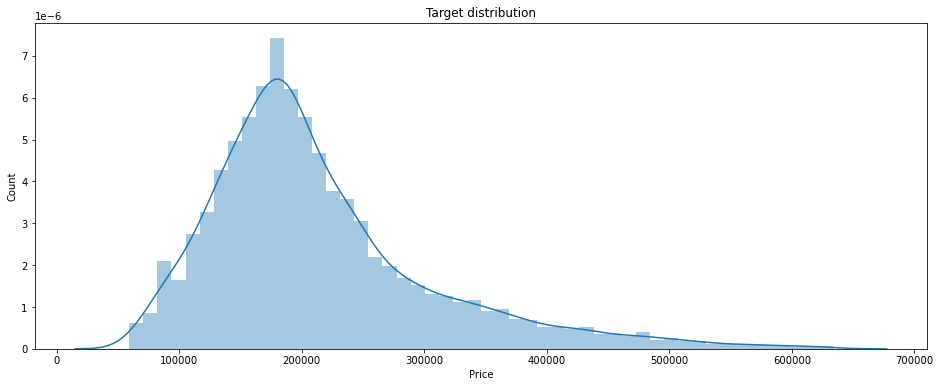

In [6]:
plt.figure(figsize = (16, 6))

sns.distplot(train_df['Price'])
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Рспределение близкое к нормальному, нет выбросов и пропусков

### Количественные переменные

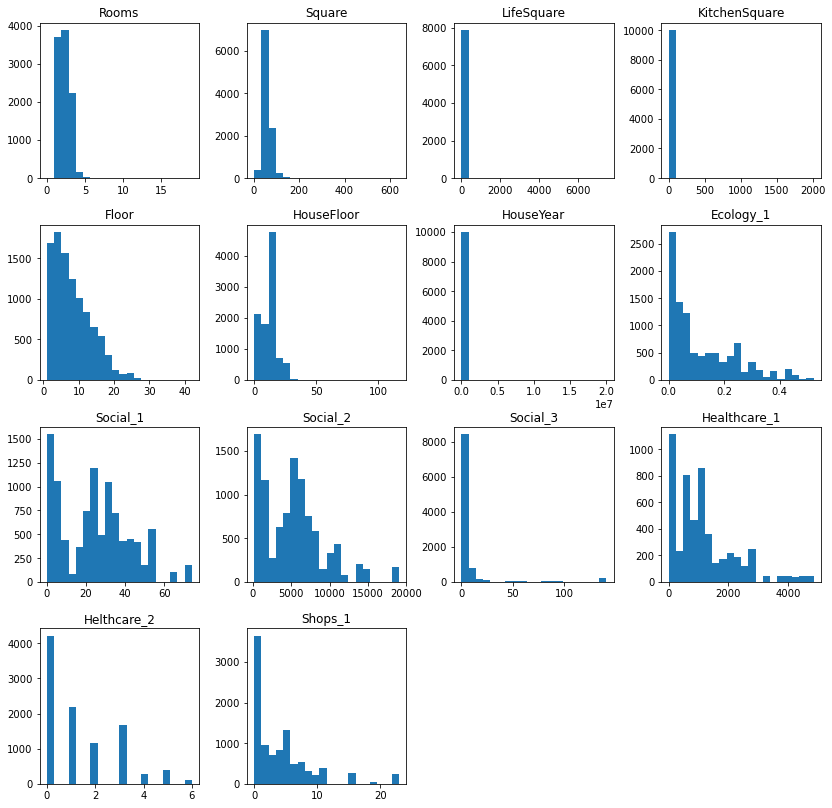

In [7]:
num_vars = train_df.copy()
non_num_vars = ['Price', 'Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']
num_vars.drop(non_num_vars, axis=1, inplace=True)
num_vars.hist(figsize=(14, 14), grid=False, bins=20)
plt.yscale(value="log")
plt.show()

### Номинативные переменные

In [8]:
# non_num_vars.remove('Price')
non_num_vars = ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']
for col in non_num_vars:
    print(col, train_df[col].value_counts(), '\n', sep='\n')

Id
1126     1
10723    1
4980     1
3234     1
8523     1
        ..
5269     1
4078     1
10280    1
14447    1
6411     1
Name: Id, Length: 10000, dtype: int64


DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
209      1
196      1
199      1
174      1
117      1
Name: DistrictId, Length: 205, dtype: int64


Ecology_2
B    9903
A      97
Name: Ecology_2, dtype: int64


Ecology_3
B    9725
A     275
Name: Ecology_3, dtype: int64


Shops_2
B    9175
A     825
Name: Shops_2, dtype: int64




### Обработка выбросов и пропусков

#### Rooms

In [9]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [10]:
train_df.loc[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


За исключением пары записей, замена 0 на 1 кажется адекватной

In [11]:
train_df.loc[train_df['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


Можно заменить на 1 или медиану, но медиана кажется более универсальной для потенциально неизветсных тестовых данных

In [12]:
train_df.loc[train_df['Rooms'] == 0] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

In [13]:
(train_df.loc[train_df['Square'] < 10]).describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,11.000000,19.000000,19.000000,19.000000
mean,1.263158,2.633356,12.156918,0.947368,7.000000,6.157895,1150.894737,0.489284,9.842105,2122.631579,1.421053,337.363636,1.000000,2.421053,162365.900232
std,0.653376,1.778970,23.529488,0.229416,8.913161,8.681162,1007.589141,0.452527,14.982446,3571.578086,1.677160,793.441904,1.154701,3.167821,182087.844313
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.007122,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.098565,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.988943,2.642219,1.000000,3.000000,1.000000,1977.000000,0.211401,1.000000,264.000000,1.000000,1.000000,1.000000,1.000000,107604.269441
75%,1.000000,4.446557,5.403368,1.000000,9.000000,10.500000,1977.000000,1.000000,12.000000,2339.500000,1.500000,260.500000,1.000000,1.500000,303594.542161
max,3.000000,5.497061,79.767964,1.000000,28.000000,25.000000,2016.000000,1.000000,53.000000,13670.000000,6.000000,2643.000000,4.000000,11.000000,483283.488083


In [14]:
(train_df.loc[train_df['Square'] > 150]).describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,25.000000,25.000000,18.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,12.000000,25.000000,25.000000,25.000000
mean,2.960000,221.983677,181.951470,11.28000,6.080000,7.960000,1991.440000,0.054743,20.28000,4883.240000,23.560000,1461.500000,1.840000,6.160000,312584.984745
std,1.306395,131.607977,137.377801,11.22319,5.597023,9.532751,25.010131,0.073487,18.95943,4825.046919,48.037381,1263.635412,1.724336,7.436845,148632.246015
min,1.000000,151.150660,76.831293,0.00000,1.000000,0.000000,1912.000000,0.000000,0.00000,186.000000,0.000000,30.000000,0.000000,0.000000,90470.430830
25%,2.000000,163.495333,102.583170,1.00000,2.000000,3.000000,1977.000000,0.004949,2.00000,475.000000,0.000000,690.000000,0.000000,0.000000,207007.956663
50%,3.000000,170.016872,157.420555,10.00000,4.000000,3.000000,1997.000000,0.014073,22.00000,5067.000000,4.000000,1046.000000,2.000000,4.000000,232766.187698
75%,4.000000,190.857689,173.806224,19.00000,7.000000,10.000000,2011.000000,0.090799,26.00000,6398.000000,6.000000,1497.500000,3.000000,7.000000,423443.464367
max,5.000000,641.065193,638.163193,32.00000,20.000000,37.000000,2019.000000,0.238617,74.00000,19083.000000,141.000000,4508.000000,6.000000,23.000000,622888.825328


Глядя на статистику и распределение признака, оптимальным кажется использование медианы для значений < 10 и > 150

In [15]:
train_df.loc[(train_df['Square'] < 10) | (train_df['Square'] > 150), 'Square'] = train_df['Square'].median()

In [16]:
train_df['Square'].describe()

count    10000.000000
mean        55.922266
std         18.069684
min         13.784865
25%         41.803396
50%         52.488511
75%         65.811609
max        148.671938
Name: Square, dtype: float64

#### LifeSquare

In [17]:
outlier_condition = (train_df['LifeSquare'] >= train_df['Square']) | (train_df['LifeSquare'].isna())
train_df.loc[outlier_condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698
9991,11173,6,2.0,62.648779,NaN,0.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.548872


Общее число записей с выбросами по жилой площади составляет около трети от всей выборки, так что хочется придумать что-то более похожее на правду, чем медиана ...

In [18]:
condition = (train_df['LifeSquare'] < train_df['Square'])
life_square_ratio = (train_df.loc[condition, 'LifeSquare'] / train_df.loc[condition, 'Square']).median()
life_square_ratio

0.61040399887381

In [19]:
min_square = train_df['Square'].min()
min_life_square = min_square * life_square_ratio
outlier_condition = (train_df['LifeSquare'] > train_df['Square']) | \
                    (train_df['LifeSquare'] < min_life_square) | \
                    (train_df['LifeSquare'].isna())
train_df.loc[outlier_condition, 'LifeSquare'] = train_df.loc[outlier_condition, 'Square'] * life_square_ratio

In [20]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        35.464530
std         13.918075
min          8.414337
25%         24.463128
50%         32.846055
75%         43.645056
max        138.004600
Name: LifeSquare, dtype: float64

#### KitchenSquare

In [21]:
(train_df.loc[train_df['KitchenSquare'] < 3]).describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.00000,3162.000000,3162.000000,1172.000000,3162.000000,3162.000000,3162.000000
mean,1.775142,59.712847,39.735401,0.783049,9.825111,12.884883,1982.575269,0.108538,11.73055,2821.885832,10.613219,735.791809,0.641366,3.225490,183945.398450
std,0.771430,18.767241,15.097909,0.415293,5.739474,8.581008,101.323698,0.122903,13.93298,3254.023753,34.319783,525.313033,1.196498,5.800005,81679.989578
min,1.000000,16.117154,8.822988,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,43.802856,27.426896,1.000000,5.000000,3.000000,1977.000000,0.007122,2.00000,469.000000,0.000000,540.000000,0.000000,0.000000,130975.339099
50%,2.000000,58.212763,37.838536,1.000000,9.000000,17.000000,1977.000000,0.072158,5.00000,1437.000000,0.000000,540.000000,0.000000,1.000000,168918.440943
75%,2.000000,68.892993,47.669230,1.000000,14.000000,17.000000,2014.000000,0.196971,22.00000,5648.000000,3.000000,1046.000000,1.000000,4.000000,211342.718124
max,5.000000,148.671938,118.048978,2.000000,37.000000,117.000000,2020.000000,1.000000,74.00000,19083.000000,141.000000,4702.000000,6.000000,23.000000,633233.466570


In [22]:
train_df.loc[train_df['KitchenSquare'] >= train_df['Square'] / 2]
(train_df['KitchenSquare'] >= train_df['Square'] / 2).sum()

35

Общее число записей с выбросами по площади кухни составляет более трети от всей выборки, так что хочется придумать что-то более похожее на правду, чем медиана ...

In [23]:
valid_square_condition = (train_df['Square'] > train_df['LifeSquare']) & \
                         (train_df['KitchenSquare'] >= 3) & \
                         (train_df['Square'] - train_df['LifeSquare'] - train_df['KitchenSquare'] > 0) & \
                         (train_df['KitchenSquare'] / train_df['Square'] < 0.5)
kitchen_ratio = (train_df.loc[valid_square_condition, 'KitchenSquare'] / 
                 train_df.loc[valid_square_condition, 'Square']).median()
kitchen_ratio

0.14740959570794343

In [24]:
outlier_condition = (train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] >= train_df['Square'] / 2)
train_df.loc[outlier_condition, 'KitchenSquare'] = train_df.loc[outlier_condition, 'Square'] * kitchen_ratio

In [25]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         8.250744
std          2.661657
min          2.032021
25%          6.000000
50%          8.000000
75%         10.000000
max         43.000000
Name: KitchenSquare, dtype: float64

#### Floor и HouseFloor

In [26]:
# По материалам, которые мне удалось найти, в России есть только три дома с жилыми квартирами и этажностью больше 50.
outlier_condition = (train_df['HouseFloor'] > 50) | (train_df['HouseFloor'] < 3)
train_df.loc[outlier_condition, 'HouseFloor'] = train_df.loc[~outlier_condition].median()
train_df['HouseFloor'].describe()

count    9179.000000
mean       13.634274
std         5.795483
min         3.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        48.000000
Name: HouseFloor, dtype: float64

In [27]:
outlier_condition = (train_df['Floor'] > train_df['HouseFloor'])
train_df.loc[outlier_condition, 'Floor'].describe()

count    1041.000000
mean       11.833814
std         5.530531
min         4.000000
25%         7.000000
50%        11.000000
75%        17.000000
max        27.000000
Name: Floor, dtype: float64

In [28]:
train_df.loc[outlier_condition, 'HouseFloor'] = train_df.loc[outlier_condition, 'Floor']
train_df['HouseFloor'].describe()

count    9179.000000
mean       13.806188
std         5.723206
min         3.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        48.000000
Name: HouseFloor, dtype: float64

#### House Year

In [29]:
outlier_condition = (train_df['HouseYear'] > 2021) | (train_df['HouseYear'] < 1900)
train_df[outlier_condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
3780,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
5894,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
6401,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
7644,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
7929,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
8828,11607,147,2.0,44.791836,28.360393,5.00000,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
9163,10814,109,1.0,37.265070,20.239714,9.00000,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
9767,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
9869,1,1,1.0,52.488511,32.039197,7.73731,1,NaN,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000


In [30]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021
train_df.loc[train_df['HouseYear'] < 1900, 'HouseYear'] = 1900
train_df['HouseYear'].describe()

count    10000.000000
mean      1984.799700
std         18.565216
min       1900.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear, dtype: float64

#### Healthcare_1

In [31]:
train_df['Healthcare_1'].count()

5208

Признак остсутствующий почти в половине наблюдений лучше убрать вообще

### Код для подготовки данных

In [32]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
#         self.kitchen_square_quantile = None
        
        self.sq_per_dis_room = None
        
#         self.remaining_space_ratio = None
        self.kitchen_ratio = None
        
        self.min_life_square = None
        self.life_square_ratio = None
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        X = X.copy()
        
        # Square
        condition = (X['Square'] >= 10) & (train_df['Square'] <= 150)
        self.square_median = X.loc[condition, 'Square'].median()
        
        # LifeSquare
        condition = (X['LifeSquare'] < X['Square'])
        self.life_square_ratio = (X.loc[condition, 'LifeSquare'] / X.loc[condition, 'Square']).median()
        
        min_square = X['Square'].min()
        self.min_life_square = min_square * life_square_ratio
        life_square_outlier_condition = (X['LifeSquare'] > X['Square']) | \
                                        (X['LifeSquare'] < self.min_life_square) | \
                                        (X['LifeSquare'].isna())
        
        # KitchenSquare
        valid_square_condition = (X['Square'] > X['LifeSquare']) & \
                                 (X['KitchenSquare'] >= 3) & \
                                 (X['Square'] - X['LifeSquare'] - X['KitchenSquare'] > 0) & \
                                 (X['KitchenSquare'] / X['Square'] < 0.5)
        self.kitchen_ratio = (X.loc[valid_square_condition, 'KitchenSquare'] / \
                              X.loc[valid_square_condition, 'Square']).median()
        
        # HouseFloor, Floor
        valid_house_floor_condition = (X['HouseFloor'] <= 50) & (X['HouseFloor'] >= 3)
        self.house_floor_median = X.loc[valid_house_floor_condition].median()

        
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        outlier_condition = (X['Square'] < 10) | (X['Square'] > 150)
        X.loc[outlier_condition, 'Square'] = self.square_median

        # LifeSquare
        outlier_condition = (X['LifeSquare'] > X['Square']) | \
                            (X['LifeSquare'] < self.min_life_square) | \
                            (X['LifeSquare'].isna())
        X.loc[outlier_condition, 'LifeSquare'] = X.loc[outlier_condition, 'Square'] * self.life_square_ratio
        
        # KitchenSquare
        outlier_condition = (X['KitchenSquare'] < 3) | (X['KitchenSquare'] >= X['Square'] / 2)
        X['Kitchen_outlier'] = 0
        X.loc[outlier_condition, 'Kitchen_outlier'] = 1        
        X.loc[outlier_condition, 'KitchenSquare'] = X.loc[outlier_condition, 'Square'] * self.kitchen_ratio

        # HouseFloor
        outlier_condition = (X['HouseFloor'] > 50) | (X['HouseFloor'] < 3)
        X.loc[outlier_condition, 'HouseFloor'] = self.house_floor_median
        
        # Floor
        outlier_condition = (X['Floor'] > X['HouseFloor'])
        X['Floor_outlier'] = 0
        X.loc[outlier_condition, 'Floor_outlier'] = 1
        X.loc[outlier_condition, 'HouseFloor'] = X.loc[outlier_condition, 'Floor']

        # HouseYear
        current_year = datetime.now().year
 
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] < 1900, 'HouseYear_outlier'] = 1

        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[X['HouseYear'] < 1900, 'HouseYear'] = 1900
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        X.fillna(self.medians, inplace=True)
        
        return X

### Новые признаки

#### DistrictSize

In [33]:
x_copy = train_df.copy()
district_size = x_copy['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27,3.0,115.027311,70.213130,10.000000,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,846
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,78
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,652
3,2352,1,1.0,40.409907,24.666369,5.956808,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,652
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,89


#### DistrictPriv

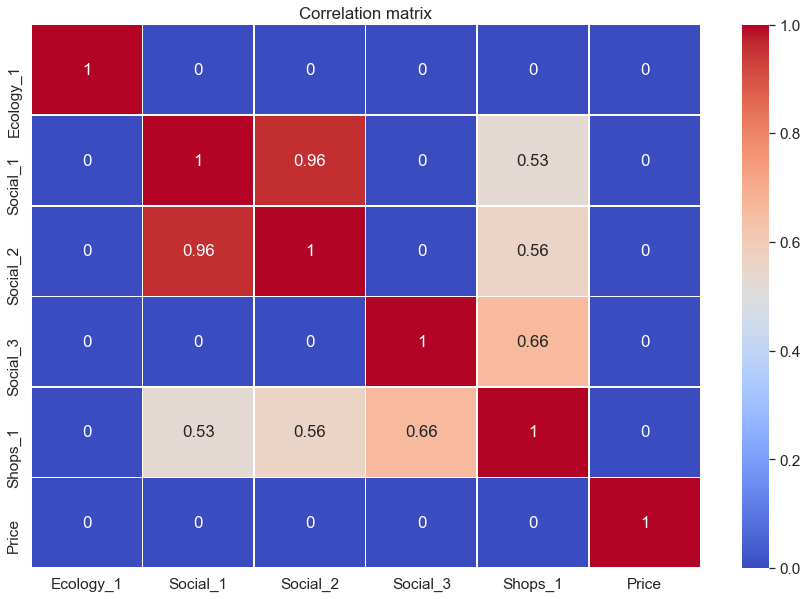

In [34]:
X_limited = train_df[['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 
                      'Shops_1', 'Price']]
X_limited.describe()

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X_limited.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Гипотеза: Есть несколько признаков, которые, по всей видимости, можно объединить в обощенный параметр "Благополучия" района. Social_1, Social_2, Social_3 и Shops_1 все имеют положительную корреляцию, и значит их можно попытаться сложить для получения некоторого обобщенного параметра. Вообще говоря их надо было бы объединять как линейную комбинацию, но мы можем попробовать частный случай с коэффициентом 1.

In [35]:
x_copy = train_df.copy()
x_copy['District_sum'] = x_copy['Shops_1'] + x_copy['Social_1'] + x_copy['Social_2'] + x_copy['Social_3']
district_priv = x_copy.groupby(['DistrictId'], as_index=False).agg({'District_sum':'median'}).\
                                    rename(columns={'District_sum':'District_priv'})
district_priv_median = district_priv['District_priv'].median()
x_copy = x_copy.merge(district_priv, on=['DistrictId'], how='left')
x_copy.fillna(district_priv_median, inplace=True)
x_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,District_sum,District_priv
0,11809,27,3.0,115.027311,70.213130,10.000000,4,10.0,2014,0.075424,...,3097,0,5546.0,0,0,B,305018.871089,846,3108,919.0
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,78,6238,6238.0
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,652,5295,266.0
3,2352,1,1.0,40.409907,24.666369,5.956808,10,22.0,1977,0.007122,...,264,0,5546.0,0,1,B,168106.007630,652,266,266.0
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,8667,2,5546.0,0,6,B,343995.102962,89,8708,8708.0


#### District_floors

Гипотеза: Многоэтажная или малоэтажная застройка района может влиять на цену.

In [36]:
x_copy = train_df.copy()
x_copy['Avg_floors'] = x_copy['HouseFloor']
district_floors = x_copy.groupby(['DistrictId'], as_index=False).agg({'Avg_floors':'median'}).\
                    rename(columns={'Avg_floors':'District_floors'})
district_floors_median = district_floors['District_floors'].median()
x_copy = x_copy.merge(district_floors, on=['DistrictId'], how='left')
x_copy.fillna(district_floors_median, inplace=True)

x_copy.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,Avg_floors,District_floors
0,11809,27,3.0,115.027311,70.213130,10.000000,4,10.0,2014,0.075424,...,3097,0,11.5,0,0,B,305018.871089,846,10.0,17.0
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,78,8.0,17.0
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,652,17.0,17.0
3,2352,1,1.0,40.409907,24.666369,5.956808,10,22.0,1977,0.007122,...,264,0,11.5,0,1,B,168106.007630,652,22.0,17.0
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,8667,2,11.5,0,6,B,343995.102962,89,16.0,12.0


## Код для создания новых признаков и оценки результатов модели

In [37]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [38]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
        # new
        self.district_priv = None
        self.district_priv_median = None
        self.district_floors = None
        self.district_floors_median = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        # DistrictWellness
        df['District_sum'] = df['Shops_1'] + df['Social_1'] + df['Social_2'] + df['Social_3']
        self.district_priv = df.groupby(['DistrictId'], as_index=False).agg({'District_sum':'median'}).\
                                            rename(columns={'District_sum':'District_priv'})
        self.district_priv_median = self.district_priv['District_priv'].median()
        
        # District_floors
        df['Avg_floors'] = df['HouseFloor']
        self.district_floors = df.groupby(['DistrictId'], as_index=False).agg({'Avg_floors':'median'}).\
                                            rename(columns={'Avg_floors':'District_floors'})
        self.district_floors_median = self.district_floors['District_floors'].median()

    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)

        # DistrictWellness
        X = X.merge(self.district_priv, on=['DistrictId'], how='left')
        X.fillna(self.district_priv_median, inplace=True)
        
        # District_floors
        X = X.merge(self.district_floors, on=['DistrictId'], how='left')
        X.fillna(self.district_floors_median, inplace=True)
            
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


In [39]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

# feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                  'Ecology_1', 'Ecology_2', 'Social_1', 'Social_2', 'Social_3',
#                  'Helthcare_2', 'Shops_1',]

# Baseeline
# new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
#                      'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

# new_feature_names = ['DistrictSize', 'new_district', 'IsDistrictLarge', 'HouseYear_outlier', 
#                      'Rooms_outlier', 'Kitchen_outlier', 'Floor_outlier', 'District_floors', 'District_priv']

new_feature_names = ['DistrictSize', 'IsDistrictLarge',  
                     'Kitchen_outlier', 'Floor_outlier', 'District_floors', 'District_priv']

# new_feature_names = ['DistrictSize', 'IsDistrictLarge',  
#                      'Kitchen_outlier', 'Floor_outlier', 'District_priv']

target_name = 'Price'

In [40]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Подготовка данных

In [41]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

orig_test_df = test_df.copy()

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

### Добавление новых признаков

In [42]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [43]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Linear Regression

In [44]:
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Lasso, Ridge, ElasticNet

# scaler = StandardScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_valid_scaled = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)

# # X_train_scaled = X_train.copy()
# # X_valid_scaled = X_valid.copy()

# # lr_model = LinearRegression()
# lr_model = Lasso(random_state = 42)
# # lr_model = Ridge(random_state = 42)

# lr_model.fit(X_train_scaled, y_train)

# plt.rcParams['figure.figsize'] = 9, 9

# plt.barh(X_train.columns, lr_model.coef_.flatten())

# plt.xlabel("Вес признака")
# plt.ylabel("Признак")

# plt.show()

# important_features = [
#     feature
#     for feature, weight in zip(X_train.columns, lr_model.coef_.flatten())
#     if np.abs(weight) > 2000
# ]

# print(important_features)
# print(lr_model.coef_)
# y_train_preds = lr_model.predict(X_train_scaled)
# y_test_preds = y_train_preds
# y_test_preds = lr_model.predict(X_valid_scaled)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

['Rooms', 'Square', 'LifeSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'DistrictSize', 'IsDistrictLarge', 'Kitchen_outlier', 'Floor_outlier', 'District_priv']
[ 13460.67535112  47375.19704841  -2375.18968729   -105.78421112
   9125.96338411   6559.81757214  -2162.03990567  -7735.97293028
   2619.36444414  -1897.28497261   1900.7123287    2183.13989234
   5122.86198232   7723.80499033  -4572.80590428   3450.74269131
 -17467.03053451 -21637.88065043  -6782.70222853  -3242.696826
  -7402.89550933]


### Подбор модели

In [45]:
# %%time

# rf_test_model = RandomForestRegressor(random_state=21, criterion='mse')
# grb_test_model = GradientBoostingRegressor(criterion='mse', random_state=42)

# params = {'n_estimators':[100, 200, 300, 400], 
#           'max_features':[8, 10, 12, 15, 20], 
#           'min_samples_leaf':[1, 3, 5, 10],
#           'max_depth':[3, 5, 7, 10]}

# gs = GridSearchCV(grb_test_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

# print(gs.best_params_)
# print(gs.best_score_)

### Random Forest

In [46]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# {'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 1, 'n_estimators': 200}
# {'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 400}

rf_model = RandomForestRegressor(random_state=21,
                                 max_depth=10,
                                 max_features=15,
                                 min_samples_leaf=1,
                                 n_estimators=200,
                                 criterion='mse')
# rf_model1 = rf_model = RandomForestRegressor(random_state=21,
#                                  max_depth=10,
#                                  max_features=12,
#                                  min_samples_leaf=3,
#                                  n_estimators=400,
#                                  criterion='mse')
rf_model.fit(X_train, y_train)
# rf_model1.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=15, n_estimators=200,
                      random_state=21)

**Оценка модели**

Train R2:	0.857
Test R2:	0.74


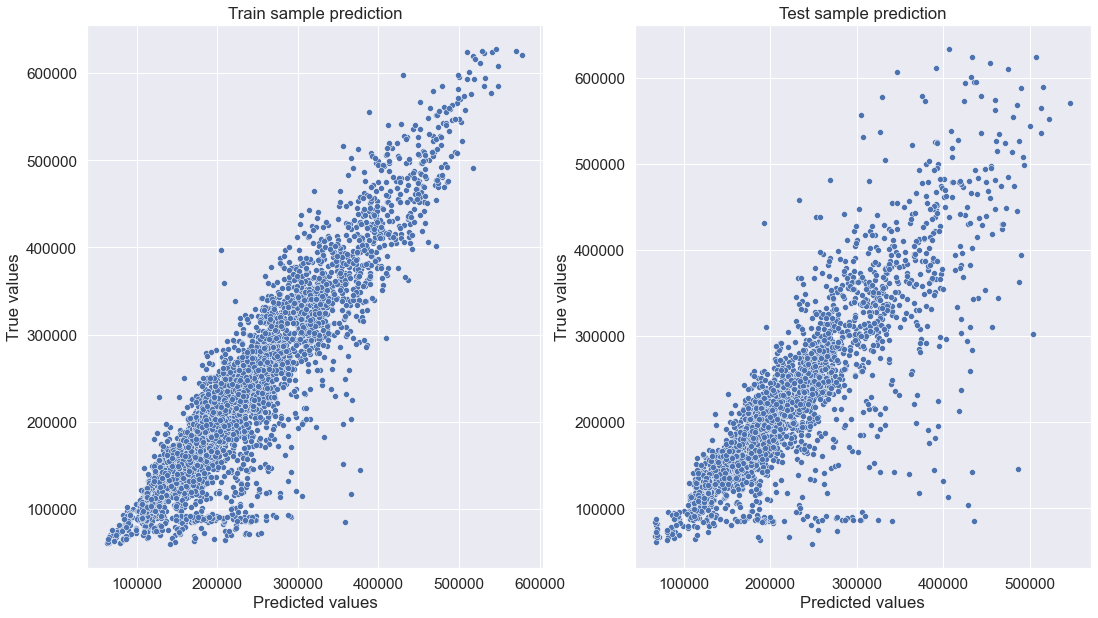

In [47]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# y_train_preds = rf_model1.predict(X_train)
# y_test_preds = rf_model1.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Важность признаков**

In [48]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.357947
16,DistrictSize,0.179510
0,Rooms,0.119263
12,Social_3,0.050756
2,LifeSquare,0.048334
17,IsDistrictLarge,0.037500
3,KitchenSquare,0.029953
7,Ecology_1,0.026801
11,Social_2,0.026058
10,Social_1,0.023894


**GradientBoosting**

Train R2:	0.9
Test R2:	0.763


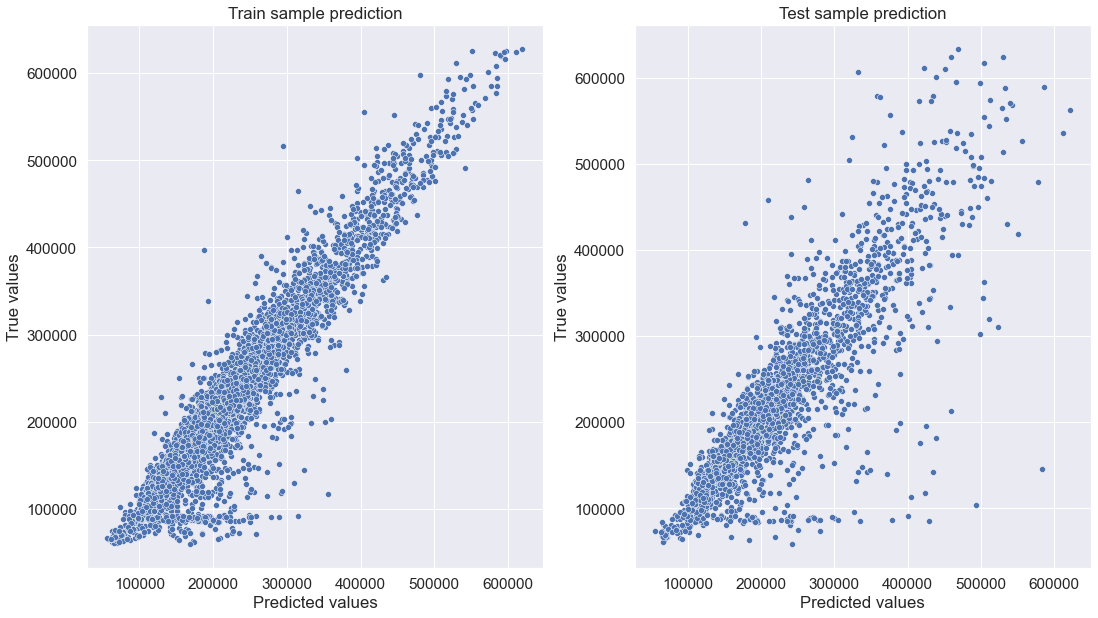

In [49]:
# {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 5, 'n_estimators': 200}
# {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 200}
grb_final_model = GradientBoostingRegressor(criterion='mse',
                                            max_depth=5,
                                            max_features=12,
                                            min_samples_leaf=3,
                                            n_estimators=200,
                                            random_state=42)

grb_final_model.fit(X_train, y_train)
y_train_preds = grb_final_model.predict(X_train)
y_test_preds = grb_final_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [50]:
feature_importances = pd.DataFrame(zip(X_train.columns, grb_final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.255804
0,Rooms,0.168312
16,DistrictSize,0.127332
2,LifeSquare,0.082198
12,Social_3,0.060713
17,IsDistrictLarge,0.044266
20,District_priv,0.036502
3,KitchenSquare,0.034607
11,Social_2,0.033300
10,Social_1,0.032899


### Stacking Regressor

In [51]:
%%time

from sklearn.ensemble import StackingRegressor

# estimators = [('rf', rf_model), ('rf1', rf_model1), ('gbr', grb_final_model)]
estimators = [('rf', rf_model), ('gbr', grb_final_model)]

# max_depth=1, min_samples_leaf=10, n_estimators=150
sclf = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(criterion='mse', 
                                                                                          max_depth=1, 
                                                                                          min_samples_leaf=10, 
                                                                                          n_estimators=150, 
                                                                                          random_state=42))

# sclf = StackingRegressor(estimators= estimators , final_estimator=GradientBoostingRegressor())


# params = {'rf__n_estimators': [100, 200, 300, 400],
#           'rf__max_features':[8, 10, 12, 15, 16], 
#           'rf__min_samples_leaf':[1, 3, 5, 10],
#           'rf__max_depth':[3, 5, 7],
#           'gbr__n_estimators': [100, 200, 300, 400],
#           'gbr__max_features':[8, 10, 12, 15, 16], 
#           'gbr__min_samples_leaf':[1, 3, 5, 10, 15],
#           'gbr__max_depth':[3, 5, 7],            
#          }

# gs = GridSearchCV(estimator=sclf, param_grid=params, cv=5)
# gs.fit(X_train, y_train)

# print(gs.best_params_)
# print(gs.best_score_)

Wall time: 0 ns


Train R2:	0.89
Test R2:	0.764


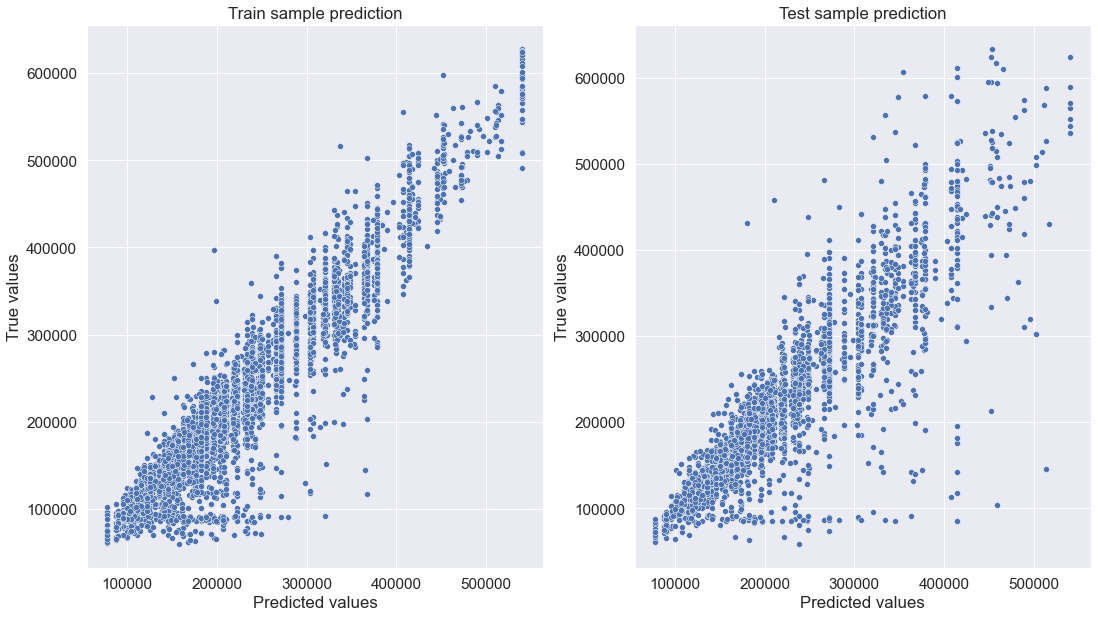

Wall time: 21.8 s


In [52]:
%%time

sclf.fit(X_train, y_train)
y_train_preds = sclf.predict(X_train)
y_test_preds = sclf.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [53]:
gbr_y_test_preds = grb_final_model.predict(test_df)
rf_y_test_preds = rf_model.predict(test_df)
# vr_y_test_preds = vr_model.predict(test_df)
sclf_y_test_preds = sclf.predict(test_df)

In [54]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [55]:
submit['Price'] = sclf_y_test_preds
submit.head()

,Id,Price
0,4567,160974.506703
1,5925,125309.739513
2,960,146169.655526
3,3848,128835.002286
4,746,204515.603057


In [56]:
submit.to_csv('sclf_submit.csv', index=False)